## 026 Mood EVRPE-CEC models (single subject)

Date: 28.Sep.2022

### Purpose

Assess if mood modeling works for new binomial batchfit models

### Outline of Plan

1. Load the new mood models from latest_cravingmood_models_binomial.py
2. Run mood modeling and save results from one participant (or a few)
3. Confirm that craving modeling still works
4. Possibly compare the craving fits to mood fits?

### What we did in this notebook

1. Steps 1-3 above
4. IC scores and correlations have to be calculated separately for craving and mood models because they are estimated separately

### Overall conclusions
1. 

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from scipy import stats
import pymc as pm
# from pymc import sampling_jax
import aesara.tensor as at
import aesara

from abc import ABC, abstractmethod

from sys import path
import os
from IPython.display import clear_output, display
import warnings

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-drug-craving/alcohol/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'
group_name = 'Social'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

from joint_models.latest_cravingmood_models_binomial import BatchFit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [5]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
model_comp_save_path = f'{project_dir}/derivatives/joint/notebooks_and_scripts/analysis_pipeline/model_comparison_df_round1.csv'
figure_save_path = f'{project_dir}/derivatives/joint/figures/'
if not os.path.exists(figure_save_path):
    os.makedirs(figure_save_path)
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.5) & 
    (df_summary['Other Accuracy']>0.5)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
longform

,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
130,6111c95332b4f21de44a25c7,135,1.0,other,1.0,1.650313e+09,1.0,1.650313e+09,1.0,1.650313e+09,1.318,fast,-1.0,-1.0,3
131,6111c95332b4f21de44a25c7,136,1.0,other,2.0,1.650313e+09,1.0,1.650313e+09,0.0,1.650313e+09,1.234,fast,5.0,-1.0,3
132,6111c95332b4f21de44a25c7,137,1.0,other,3.0,1.650313e+09,0.0,1.650313e+09,0.0,1.650313e+09,0.634,slow,-1.0,-1.0,3
133,6111c95332b4f21de44a25c7,139,1.0,other,4.0,1.650313e+09,1.0,1.650313e+09,1.0,1.650313e+09,0.750,slow,-1.0,-1.0,3
134,6111c95332b4f21de44a25c7,141,1.0,other,5.0,1.650313e+09,1.0,1.650313e+09,1.0,1.650313e+09,0.818,fast,4.0,35.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,5ca25f7048f78e0018fdac10,6479,2.0,money,56.0,1.650378e+09,0.0,1.650378e+09,0.0,1.650378e+09,0.629,slow,-1.0,-1.0,54
5996,5ca25f7048f78e0018fdac10,6480,2.0,money,57.0,1.650378e+09,1.0,1.650378e+09,0.0,1.650378e+09,0.146,slow,-1.0,-1.0,54
5997,5ca25f7048f78e0018fdac10,6482,2.0,money,58.0,1.650378e+09,0.0,1.650378e+09,1.0,1.650378e+09,0.046,fast,-1.0,-1.0,54
5998,5ca25f7048f78e0018fdac10,6483,2.0,money,59.0,1.650378e+09,0.0,1.650378e+09,0.0,1.650378e+09,0.126,fast,-1.0,-1.0,54


## Fit models

In [87]:
save_path = f'{root_dir}/bayesian_models/slotscraving/exploration/26_trace_output/'
save_mood_path = f'{root_dir}/bayesian_models/slotscraving/exploration/26_mood_trace_output/'

In [88]:
batchfit = BatchFit(
        [
            'P_RW_0step',
            # 'P_RW_1stepMean', 'P_RW_1stepDecay', 'P_RW_1stepSep',
            # 'P_RW_2stepMean', 'P_RW_2stepDecay', 'P_RW_2stepSep',
            # 'P_RWSep_0step',
            # 'P_RWSep_1stepMean', 'P_RWSep_1stepDecay', 'P_RWSep_1stepSep',
            # 'P_RWSep_2stepMean', 'P_RWSep_2stepDecay', 'P_RWSep_2stepSep',
            'A_RW_0step',
            # 'A_RW_1stepMean', 'A_RW_1stepDecay', 'A_RW_1stepSep',
            # 'A_RW_2stepMean', 'A_RW_2stepDecay', 'A_RW_2stepSep',
            # 'A_RWSep_0step',
            # 'A_RWSep_1stepMean', 'A_RWSep_1stepDecay', 'A_RWSep_1stepSep',
            # 'A_RWSep_2stepMean', 'A_RWSep_2stepDecay', 'A_RWSep_2stepSep',
            'A_Beta_RW_0step',
            # 'A_Beta_RW_1stepMean', 'A_Beta_RW_1stepDecay', 'A_Beta_RW_1stepSep',
            # 'A_Beta_RW_2stepMean', 'A_Beta_RW_2stepDecay', 'A_Beta_RW_2stepSep',
            # 'A_Beta_RWSep_0step',
            # 'A_Beta_RWSep_1stepMean', 'A_Beta_RWSep_1stepDecay', 'A_Beta_RWSep_1stepSep',
            # 'A_Beta_RWSep_2stepMean', 'A_Beta_RWSep_2stepDecay', 'A_Beta_RWSep_2stepSep',
            'BiasedCEC',
            'HeuCEC', 'RWCEC'
        ],
        longform,
        df_summary,
        project_dir,
        save_path,
        save_mood_path
    )

## Load trace data for all models

In [89]:
# for pid_num in np.arange(len(pid_list)):
# for pid_num in [7, 15, 16]:
for pid_num in [7]:
    batchfit.fit_mood(pid_num, 'money', jupyter=True)
    batchfit.fit_mood(pid_num, 'other', jupyter=True)

    batchfit.fit(pid_num, 'money', jupyter=True)
    batchfit.fit(pid_num, 'other', jupyter=True)

Fitting RWCEC: PID - 7, Block - other
PID: 5cf5134c8f8ff80019e76721, Block other exists, loading from file...


## Plotting utils

In [90]:
def plot_ppc(batchfit, pid_num, block):
    n_rows = int(np.ceil(len(batchfit.models)/4))
    fig, ax = plt.subplots(ncols=4, nrows=n_rows, figsize=(18,n_rows*2), facecolor='w', edgecolor='k')
    row_ind = 0
    col_ind = 0
    for model_name in batchfit.models:
        model = batchfit.models[model_name]
        posterior_pred = model.traces[block][model.pid_list[pid_num]].posterior_predictive.like[0]
        for i, row in enumerate(posterior_pred):
            sns.scatterplot(x=np.arange(len(row)), y=row, color='blue', alpha=0.01, ax=ax[row_ind, col_ind])
            if i > 50:
                break
        # az.plot_hdi(x=np.arange(posterior_pred.shape[1]), y=posterior_pred, hdi_prob=0.60, ax=ax[row_ind, col_ind])
        pid_act = model.longform[(model.longform['PID']==model.pid_list[pid_num]) & (model.longform['Type']==block)]['Action'].values
        sns.scatterplot(x=np.arange(len(pid_act)), y=pid_act+0.1, color='red', ax=ax[row_ind, col_ind])
        ax[row_ind, col_ind].set_title(f'{model_name}')
        if col_ind == 3:
            col_ind = 0
            row_ind += 1
        else:
            col_ind += 1
    plt.tight_layout()
    plt.close()
    return fig

In [91]:
def plot_ppc_craving(batchfit, pid_num, block):
    b = 0 if block=='money' else 1
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
    model_names = list(batchfit.models.keys())
    samp_model = batchfit.models[model_names[0]]
    sns.lineplot(
        x=np.arange(samp_model.cravings[b, pid_num].shape[0]),
        y=samp_model.cravings[b, pid_num],
        label='True craving',
        color='black'
    )
    for model_name in batchfit.models:
        model = batchfit.models[model_name]
        sns.lineplot(
            x=np.arange(len(model.cravings[b, pid_num])),
            y=model.traces[block][model.pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
            # label=f'{model_name}'
        )
    plt.tight_layout()
    plt.close()
    return fig


In [97]:
def plot_ppc_mood(batchfit, pid_num, block):
    b = 0 if block=='money' else 1
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
    model_names = list(batchfit.models.keys())
    samp_model = batchfit.models[model_names[0]]
    sns.lineplot(
        x=np.arange(samp_model.moods[b, pid_num].shape[0]),
        y=samp_model.moods[b, pid_num],
        label='True mood',
        color='black'
    )
    for model_name in batchfit.models:
        model = batchfit.models[model_name]
        sns.lineplot(
            x=np.arange(len(model.moods[b, pid_num])),
            y=model.mood_traces[block][model.pid_list[pid_num]].posterior_predictive.mood_like.values[0].mean(axis=0),
            # label=f'{model_name}'
        )
    plt.tight_layout()
    plt.close()
    return fig


In [93]:
def plot_indivsub_model_comp(batchfit, pid_num, block, ic='waic', var_name='like'):
    model_comp = az.compare({
        k: v.traces[block][v.pid_list[pid_num]] for k, v in batchfit.models.items()
    },
    ic=ic,
    var_name=var_name)
    display(model_comp)
    az.plot_compare(model_comp,insample_dev=True, figsize=(12,10))


In [94]:
def plot_indivsub_craving_mood_like_comp(batchfit, pid_num, block, ic='waic'):
    craving_model_like = {
        k: v.traces[block][v.pid_list[pid_num]] for k, v in batchfit.models.items()
    }
    mood_model_like = {
        f'mood_{k}': v.traces[block][v.pid_list[pid_num]] for k, v in batchfit.models.items()
    }
    model_comp = az.compare({
        **craving_model_like,
        **mood_model_like
    },
    ic=ic,
    var_name='like')
    display(model_comp)
    az.plot_compare(model_comp,insample_dev=True, figsize=(12,10))


## Spot check PPC for individual subjects

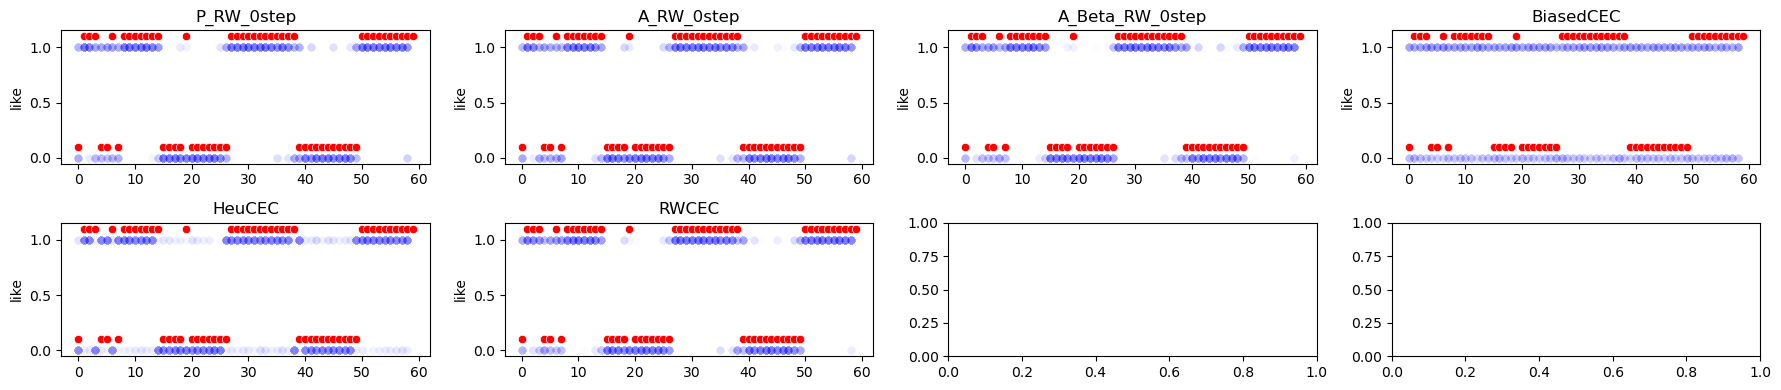

In [95]:
plot_ppc(batchfit, 7, 'other')

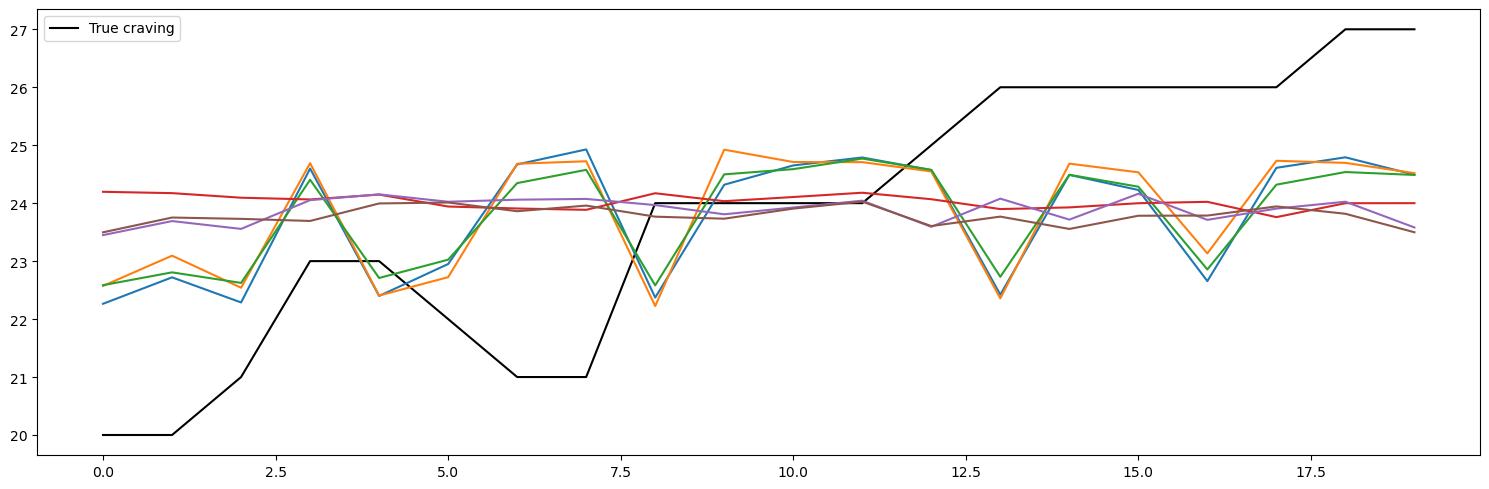

In [99]:
plot_ppc_craving(batchfit, 7, 'other')

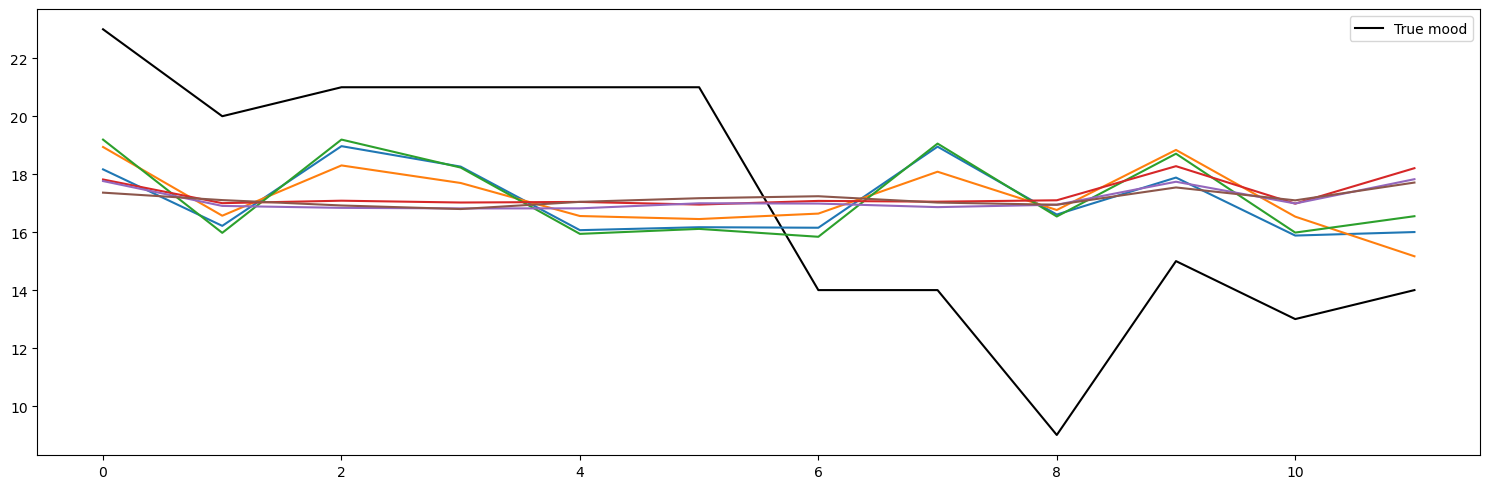

In [ ]:
plot_ppc_mood(batchfit, 7, 'other')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
A_RW_0step,0,-12.422930,0.755841,0.000000,0.827752,2.896930,0.000000,True,log
A_Beta_RW_0step,1,-13.004142,0.603892,0.581212,0.000000,3.020675,0.466567,False,log
RWCEC,2,-13.030556,0.603398,0.607626,0.000000,3.005499,0.462649,False,log
P_RW_0step,3,-13.101117,0.639973,0.678187,0.000000,3.056104,0.529174,False,log
HeuCEC,4,-15.718266,0.590313,3.295337,0.172248,4.364953,3.368935,False,log
BiasedCEC,5,-41.228073,1.016423,28.805143,0.000000,1.106378,3.051639,False,log


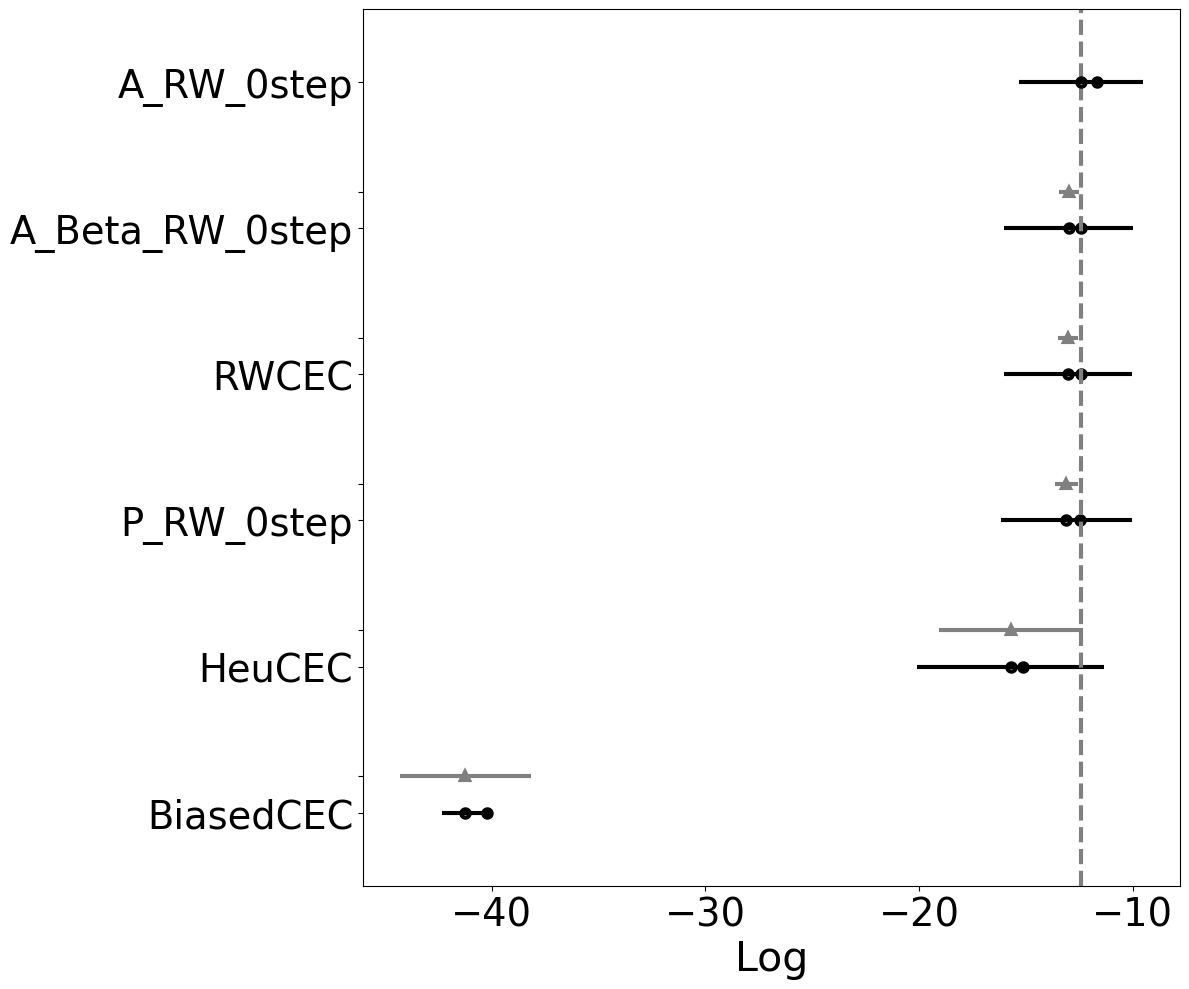

In [100]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_indivsub_model_comp(batchfit, 7, 'other', var_name='like')
    plt.tight_layout()

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
A_RW_0step,0,-12.422930,0.755841,0.000000,4.137893e-01,2.896930,0.000000,True,log
mood_A_RW_0step,1,-12.422930,0.755841,0.000000,4.137893e-01,2.896930,0.000000,True,log
A_Beta_RW_0step,2,-13.004142,0.603892,0.581212,7.557177e-12,3.020675,0.466567,False,log
mood_A_Beta_RW_0step,3,-13.004142,0.603892,0.581212,7.587594e-12,3.020675,0.466567,False,log
RWCEC,4,-13.030556,0.603398,0.607626,7.571509e-12,3.005499,0.462649,False,log
mood_RWCEC,5,-13.030556,0.603398,0.607626,7.568250e-12,3.005499,0.462649,False,log
P_RW_0step,6,-13.101117,0.639973,0.678187,7.543903e-12,3.056104,0.529174,False,log
mood_P_RW_0step,7,-13.101117,0.639973,0.678187,7.555020e-12,3.056104,0.529174,False,log
HeuCEC,8,-15.718266,0.590313,3.295337,8.621068e-02,4.364953,3.368935,False,log
mood_HeuCEC,9,-15.718266,0.590313,3.295337,8.621068e-02,4.364953,3.368935,False,log


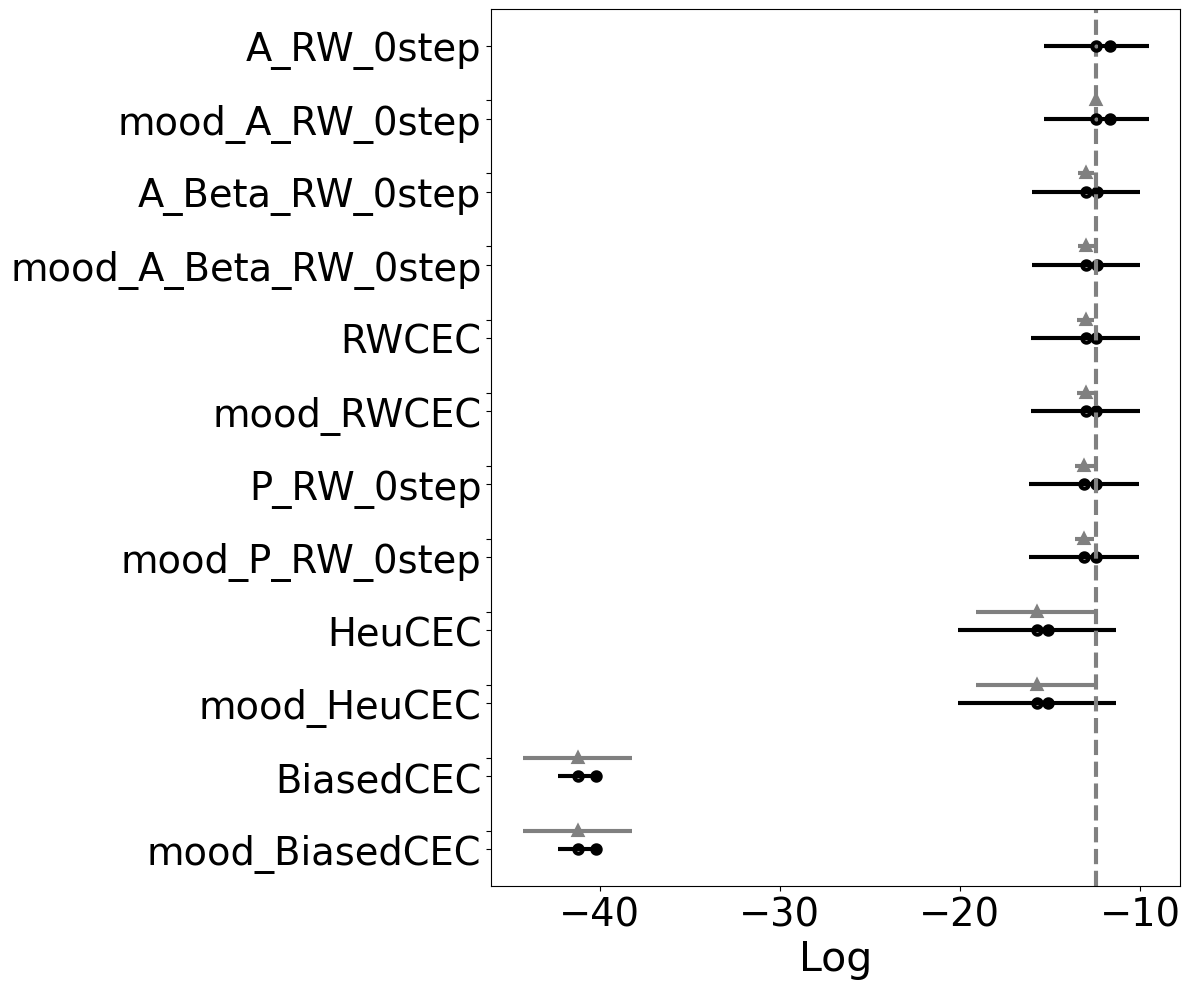

In [101]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_indivsub_craving_mood_like_comp(batchfit, 7, 'other')
    plt.tight_layout()

## Model aggregate comparison

In [13]:
def agg_model_comp(batchfit, ic='waic'):
    n_blocks = 2
    like_dist = np.zeros((df_summary.shape[0], n_blocks, len(batchfit.models)))
    craving_like_dist = np.zeros((df_summary.shape[0], n_blocks, len(batchfit.models)))
    samp_model_name = list(batchfit.models.keys())[0]
    pids_to_skip = []

    phase1_handle = display('Calculating comparison statistics for each participant...', display_id=True)
    phase1_update = display('', display_id=True)
    for s, pid in enumerate(batchfit.models[samp_model_name].traces['money'].keys()):
        if batchfit.models[samp_model_name].std_craving[0, s] == 0 or batchfit.models[samp_model_name].std_craving[1, s] == 0:
            phase1_update.update(f'No variance in craving ratings for {s}: {pid}')
            pids_to_skip.append(pid)
            continue
        phase1_update.update(f'Comparison for participant {s}: {pid}')
        for i, block in enumerate(['money', 'other']):
            try:
                trace_dict = {
                    k: v.traces[block][pid] for k, v in batchfit.models.items()
                }
                comp = az.compare(trace_dict, ic=ic, var_name='like')
                for j, name in enumerate(batchfit.models.keys()):
                    like_dist[s, i, j] = comp.loc[name]['d_waic']
                craving_comp = az.compare(trace_dict, ic=ic, var_name='craving_like')
                for j, name in enumerate(batchfit.models.keys()):
                    craving_like_dist[s, i, j] = craving_comp.loc[name]['d_waic']
            except TypeError:
                pass
    phase1_update.update('Phase 1 complete!')

    d_waic_df = pd.DataFrame()
    phase2_handle = display('Calculating DICs for each participant...', display_id=True)
    phase2_update = display('', display_id=True)

    for i, name in enumerate(batchfit.models.keys()):
        for s, pid in enumerate(batchfit.models[samp_model_name].traces['money'].keys()):
            if pid in pids_to_skip:
                phase2_update.update(f'Model #{i}: {name}, skipping DIC scoring for participant {s}: {pid}')
                continue
            block_dics = []
            for j, block in enumerate(['money', 'other']):            
                phase2_update.update(f'Model #{i}: {name}, DIC scoring for participant {s}: {pid}')
                try:
                    lls = np.array([np.sum(stats.binom.logpmf(k=batchfit.models[name].cravings[1, s, :], n=50, p=samp_probs)) 
                        for samp_probs in np.concatenate(batchfit.models[name].traces[block][pid].posterior.prob_craving, axis=0)])
                    p_dic = 2*(lls - np.mean(lls))
                    dic = -2*lls + 2*p_dic
                except AttributeError:
                    lls = np.array([np.sum(stats.binom.logpmf(k=batchfit.models[name].cravings[1, s, :], n=50, p=samp_probs)) 
                        for samp_probs in np.concatenate(batchfit.models[name].traces[block][pid].posterior.probs_craving, axis=0)])
                    p_dic = 2*(lls - np.mean(lls))
                    dic = -2*lls + 2*p_dic
                block_dics.append(dic.mean())
            
            d_waic_df = pd.concat([d_waic_df,
                pd.DataFrame({
                    'Model': name,
                    'PID': [pid, pid],
                    'PID Num': [s, s],
                    'Type': batchfit.models[name].type,
                    'Retro': batchfit.models[name].retro,
                    'Decision': batchfit.models[name].decision,
                    'Craving': batchfit.models[name].craving,
                    'Block': ['money', 'other'],
                    'd_waic_like': like_dist[s, :, i],
                    'd_waic_craving': craving_like_dist[s, :, i],
                    'Mean DIC': block_dics
                })
            ])
    for s, pid_num in enumerate(d_waic_df['PID Num'].unique()):
        for block in ['money', 'other']:
            subset = d_waic_df.loc[
                (d_waic_df['PID Num']==pid_num) &
                (d_waic_df['Block']==block)
            ].copy()

            d_waic_df.loc[
                (d_waic_df['PID Num']==pid_num) &
                (d_waic_df['Block']==block)
            ,'dDIC'] = subset['Mean DIC'] - subset['Mean DIC'].min()

    phase2_update.update('Phase 2 complete!')
    return d_waic_df, pids_to_skip

In [14]:
def refactored_agg_model_comp(batchfit, ic='loo'):
    samp_model_name = list(batchfit.models.keys())[0]
    pids_to_skip = []

    model_comp_df = pd.DataFrame()

    title_handle = display('Calculating comparison statistics for each participant...', display_id=True)
    update_handle = display('', display_id=True)
    for s, pid in enumerate(batchfit.models[samp_model_name].traces['money'].keys()):
        if batchfit.models[samp_model_name].std_craving[0, s] == 0 or batchfit.models[samp_model_name].std_craving[1, s] == 0:
            update_handle.update(f'No variance in craving ratings for {s}: {pid}')
            pids_to_skip.append(pid)
            continue
        for b, block in enumerate(['money', 'other']):
            update_handle.update(f'Comparison for participant {s}: {pid}, block {block}')
            block_model_names = []
            block_model_types = []
            block_model_retros = []
            block_model_decision_types = []
            block_model_craving_types = []
            block_model_loo = []
            block_model_d_loo = []
            block_model_craving_loo = []
            block_model_craving_d_loo = []
            block_model_craving_dic = []
            block_model_craving_d_dic = []
            try:
                trace_dict = {
                    k: v.traces[block][pid] for k, v in batchfit.models.items()
                }
                like_comp = az.compare(trace_dict, ic=ic, var_name='like')
                craving_comp = az.compare(trace_dict, ic=ic, var_name='craving_like')
                for j, name in enumerate(batchfit.models.keys()):
                    block_model_names.append(name)
                    block_model_types.append(batchfit.models[name].type)
                    block_model_retros.append(batchfit.models[name].retro)
                    block_model_decision_types.append(batchfit.models[name].decision)
                    block_model_craving_types.append(batchfit.models[name].craving)
                    block_model_loo.append(like_comp.loc[name][ic])
                    block_model_d_loo.append(like_comp.loc[name][f'd_{ic}'])
                    block_model_craving_loo.append(craving_comp.loc[name][ic])
                    block_model_craving_d_loo.append(craving_comp.loc[name][f'd_{ic}'])
                    try:
                        lls = np.array([np.sum(stats.binom.logpmf(k=batchfit.models[name].cravings[1, s, :], n=50, p=samp_probs)) 
                            for samp_probs in np.concatenate(batchfit.models[name].traces[block][pid].posterior.prob_craving, axis=0)])
                        p_dic = 2*(lls - np.mean(lls))
                        dic = -2*lls + 2*p_dic
                    except AttributeError:
                        lls = np.array([np.sum(stats.binom.logpmf(k=batchfit.models[name].cravings[1, s, :], n=50, p=samp_probs)) 
                            for samp_probs in np.concatenate(batchfit.models[name].traces[block][pid].posterior.probs_craving, axis=0)])
                        p_dic = 2*(lls - np.mean(lls))
                        dic = -2*lls + 2*p_dic
                    block_model_craving_dic.append(dic.mean())
                block_model_craving_d_dic = np.array(block_model_craving_dic) - np.array(block_model_craving_dic).min()
            except TypeError:
                print('Encountered TypeError for', pid, block)
            
            model_comp_df = pd.concat([model_comp_df,
                pd.DataFrame({
                    'Model': block_model_names,
                    'PID': pid,
                    'PID Num': s,
                    'Type': block_model_types,
                    'Retro': block_model_retros,
                    'Decision': block_model_decision_types,
                    'Craving': block_model_craving_types,
                    'Block': block,
                    f'like_{ic}': block_model_loo,
                    f'like_d_{ic}': block_model_d_loo,
                    f'craving_like_{ic}': block_model_craving_loo,
                    f'craving_like_d_{ic}': block_model_craving_d_loo,
                    'craving_dic': block_model_craving_dic,
                    'craving_d_dic': block_model_craving_d_dic
                })
            ])
    return model_comp_df, pids_to_skip

In [26]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    if os.path.exists(model_comp_save_path):
        model_comp_df = pd.read_csv(model_comp_save_path, index_col=0).reset_index(drop=True)
        model_comp_df['Type'].replace(np.nan, 'null', inplace=True)
    else:
        model_comp_df, pids_skipped = refactored_agg_model_comp(batchfit, ic='loo')
        model_comp_df.to_csv(model_comp_save_path)

In [27]:
model_comp_df

,Model,PID,PID Num,Type,Retro,Decision,Craving,Block,like_loo,like_d_loo,craving_like_loo,craving_like_d_loo,craving_dic,craving_d_dic
0,P_RW_0step,6033371e8e3b1e3de81da9b2,0,passive,0,RW,EVRPE_CEC,money,-13.336479,0.829662,-45.506768,1.155114,178.289721,1.987994
1,P_RW_1stepMean,6033371e8e3b1e3de81da9b2,0,passive,1,RW,EVRPE_CEC,money,-13.158181,0.651364,-45.076594,0.724939,178.081784,1.780056
2,P_RW_1stepDecay,6033371e8e3b1e3de81da9b2,0,passive,1,RW,EVRPE_CEC,money,-13.333682,0.826865,-45.454839,1.103185,179.101402,2.799674
3,P_RW_1stepSep,6033371e8e3b1e3de81da9b2,0,passive,1,RW,EVRPE_CEC,money,-13.218945,0.712128,-45.119102,0.767448,177.372613,1.070886
4,P_RW_2stepMean,6033371e8e3b1e3de81da9b2,0,passive,2,RW,EVRPE_CEC,money,-13.161047,0.654230,-45.190309,0.838655,177.642550,1.340823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,A_Beta_RWSep_2stepDecay,588e8b95670d6600012bd8dc,32,active_beta,2,RWSep,EVRPE_CEC,other,-29.863644,1.046202,-25.200527,2.437698,42.208861,3.085750
2966,A_Beta_RWSep_2stepSep,588e8b95670d6600012bd8dc,32,active_beta,2,RWSep,EVRPE_CEC,other,-29.371105,0.553663,-23.625183,0.862354,40.312760,1.189649
2967,BiasedCEC,588e8b95670d6600012bd8dc,32,null,0,Biased,CEC,other,-35.460143,6.642702,-24.569002,1.806173,46.546876,7.423765
2968,HeuCEC,588e8b95670d6600012bd8dc,32,null,0,Heuristic,CEC,other,-38.748454,9.931013,-24.494397,1.731569,46.424814,7.301703


In [28]:
model_comp_df.groupby(['Type', 'Block']).mean().sort_values('like_d_loo', ascending=True)

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_61009/2237253022.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model_comp_df.groupby(['Type', 'Block']).mean().sort_values('like_d_loo', ascending=True)


PID Num     Retro   like_loo  like_d_loo  craving_like_loo  \
Type        Block                                                               
active_lr   other     16.0  1.285714 -27.241323    1.147981        -66.801039   
active_beta other     16.0  1.285714 -27.418589    1.325247        -66.267026   
passive     other     16.0  1.285714 -27.430000    1.336659        -66.346896   
active_lr   money     16.0  1.285714 -26.037246    1.353175        -70.748818   
passive     money     16.0  1.285714 -26.389909    1.705838        -70.467966   
active_beta money     16.0  1.285714 -26.396519    1.712447        -70.410985   
null        money     16.0  0.000000 -32.047924    7.363853        -74.463174   
            other     16.0  0.000000 -33.567771    7.474430        -68.394648   

                   craving_like_d_loo  craving_dic  craving_d_dic  
Type        Block                                                  
active_lr   other            7.174566   119.990906      12.815158  
active_beta other            6.640552   121.869355      14.693607  
passive     other            6.720423   121.834973      14.659225  
active_lr   money            8.300040   225.087872      27.409060  
passive     money            8.019188   221.434667      23.755854  
active_beta money            7.962206   221.442682      23.763870  
null        money           12.014395   201.603856       3.925044  
            other            8.768175   131.107030      23.931282

In [29]:
model_comp_df.groupby(['Type', 'Decision', 'Craving', 'Retro', 'Block']).mean().sort_values('craving_like_d_loo', ascending=True)

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_61009/1469488717.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model_comp_df.groupby(['Type', 'Decision', 'Craving', 'Retro', 'Block']).mean().sort_values('craving_like_d_loo', ascending=True)


PID Num   like_loo  like_d_loo  \
Type        Decision  Craving   Retro Block                                   
active_beta RWSep     EVRPE_CEC 2     other     16.0 -27.486776    1.393434   
                                0     other     16.0 -27.564531    1.471189   
passive     RWSep     EVRPE_CEC 0     other     16.0 -27.577313    1.483971   
                                2     other     16.0 -27.507451    1.414109   
active_lr   RWSep     EVRPE_CEC 2     other     16.0 -27.364205    1.270863   
                                0     other     16.0 -27.270898    1.177556   
passive     RWSep     EVRPE_CEC 1     other     16.0 -27.458069    1.364727   
active_beta RWSep     EVRPE_CEC 1     other     16.0 -27.431872    1.338530   
passive     RW        EVRPE_CEC 0     other     16.0 -27.454610    1.361269   
                                2     money     16.0 -26.436138    1.752067   
active_beta RW        EVRPE_CEC 0     other     16.0 -27.352125    1.258784   
                                2     money     16.0 -26.307705    1.623634   
passive     RW        EVRPE_CEC 2     other     16.0 -27.380750    1.287409   
active_beta RW        EVRPE_CEC 2     other     16.0 -27.411460    1.318119   
active_lr   RW        EVRPE_CEC 2     other     16.0 -27.216556    1.123214   
active_beta RW        EVRPE_CEC 1     other     16.0 -27.346284    1.252942   
active_lr   RWSep     EVRPE_CEC 1     other     16.0 -27.498476    1.405135   
            RW        EVRPE_CEC 0     other     16.0 -27.020776    0.927434   
active_beta RWSep     EVRPE_CEC 2     money     16.0 -26.366732    1.682661   
passive     RWSep     EVRPE_CEC 2     money     16.0 -26.376811    1.692740   
            RW        EVRPE_CEC 1     other     16.0 -27.316424    1.223082   
active_lr   RW        EVRPE_CEC 2     money     16.0 -26.028961    1.344890   
            RWSep     EVRPE_CEC 2     money     16.0 -25.991244    1.307173   
            RW        EVRPE_CEC 1     other     16.0 -27.086903    0.993562   
            RWSep     EVRPE_CEC 1     money     16.0 -26.235682    1.551610   
            RW        EVRPE_CEC 1     money     16.0 -26.061867    1.377795   
active_beta RW        EVRPE_CEC 1     money     16.0 -26.467206    1.783134   
passive     RW        EVRPE_CEC 0     money     16.0 -26.234843    1.550772   
                                1     money     16.0 -26.441695    1.757623   
active_beta RW        EVRPE_CEC 0     money     16.0 -26.442031    1.757959   
            RWSep     EVRPE_CEC 1     money     16.0 -26.473578    1.789507   
null        Biased    CEC       0     other     16.0 -40.473846   14.380504   
            RW        CEC       0     other     16.0 -27.045047    0.951705   
            Heuristic CEC       0     other     16.0 -33.184421    7.091079   
passive     RWSep     EVRPE_CEC 1     money     16.0 -26.405209    1.721137   
active_beta RWSep     EVRPE_CEC 0     money     16.0 -26.269938    1.585867   
passive     RWSep     EVRPE_CEC 0     money     16.0 -26.244327    1.560256   
active_lr   RW        EVRPE_CEC 0     money     16.0 -25.939423    1.255351   
            RWSep     EVRPE_CEC 0     money     16.0 -25.802577    1.118505   
null        Biased    CEC       0     money     16.0 -39.343317   14.659246   
            Heuristic CEC       0     money     16.0 -31.033078    6.349006   
            RW        CEC       0     money     16.0 -25.767377    1.083305   

                                             craving_like_loo  \
Type        Decision  Craving   Retro Block                     
active_beta RWSep     EVRPE_CEC 2     other        -65.271151   
                                0     other        -65.343888   
passive     RWSep     EVRPE_CEC 0     other        -65.395918   
                                2     other        -65.571144   
active_lr   RWSep     EVRPE_CEC 2     other        -65.698988   
                                0     other        -66.078193   
passive     RWSep     EVRPE_CEC 1     other     

In [30]:
model_comp_df.groupby(['Type', 'Decision', 'Craving', 'Retro', "Block"]).mean().sort_values('like_d_loo', ascending=True)

/var/folders/p4/n3rrj_kd3n76hx_5y5q4qvfh0000gn/T/ipykernel_61009/2234237011.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  model_comp_df.groupby(['Type', 'Decision', 'Craving', 'Retro', "Block"]).mean().sort_values('like_d_loo', ascending=True)


PID Num   like_loo  like_d_loo  \
Type        Decision  Craving   Retro Block                                   
active_lr   RW        EVRPE_CEC 0     other     16.0 -27.020776    0.927434   
null        RW        CEC       0     other     16.0 -27.045047    0.951705   
active_lr   RW        EVRPE_CEC 1     other     16.0 -27.086903    0.993562   
null        RW        CEC       0     money     16.0 -25.767377    1.083305   
active_lr   RWSep     EVRPE_CEC 0     money     16.0 -25.802577    1.118505   
            RW        EVRPE_CEC 2     other     16.0 -27.216556    1.123214   
            RWSep     EVRPE_CEC 0     other     16.0 -27.270898    1.177556   
passive     RW        EVRPE_CEC 1     other     16.0 -27.316424    1.223082   
active_beta RW        EVRPE_CEC 1     other     16.0 -27.346284    1.252942   
active_lr   RW        EVRPE_CEC 0     money     16.0 -25.939423    1.255351   
active_beta RW        EVRPE_CEC 0     other     16.0 -27.352125    1.258784   
active_lr   RWSep     EVRPE_CEC 2     other     16.0 -27.364205    1.270863   
passive     RW        EVRPE_CEC 2     other     16.0 -27.380750    1.287409   
active_lr   RWSep     EVRPE_CEC 2     money     16.0 -25.991244    1.307173   
active_beta RW        EVRPE_CEC 2     other     16.0 -27.411460    1.318119   
            RWSep     EVRPE_CEC 1     other     16.0 -27.431872    1.338530   
active_lr   RW        EVRPE_CEC 2     money     16.0 -26.028961    1.344890   
passive     RW        EVRPE_CEC 0     other     16.0 -27.454610    1.361269   
            RWSep     EVRPE_CEC 1     other     16.0 -27.458069    1.364727   
active_lr   RW        EVRPE_CEC 1     money     16.0 -26.061867    1.377795   
active_beta RWSep     EVRPE_CEC 2     other     16.0 -27.486776    1.393434   
active_lr   RWSep     EVRPE_CEC 1     other     16.0 -27.498476    1.405135   
passive     RWSep     EVRPE_CEC 2     other     16.0 -27.507451    1.414109   
active_beta RWSep     EVRPE_CEC 0     other     16.0 -27.564531    1.471189   
passive     RWSep     EVRPE_CEC 0     other     16.0 -27.577313    1.483971   
            RW        EVRPE_CEC 0     money     16.0 -26.234843    1.550772   
active_lr   RWSep     EVRPE_CEC 1     money     16.0 -26.235682    1.551610   
passive     RWSep     EVRPE_CEC 0     money     16.0 -26.244327    1.560256   
active_beta RWSep     EVRPE_CEC 0     money     16.0 -26.269938    1.585867   
            RW        EVRPE_CEC 2     money     16.0 -26.307705    1.623634   
            RWSep     EVRPE_CEC 2     money     16.0 -26.366732    1.682661   
passive     RWSep     EVRPE_CEC 2     money     16.0 -26.376811    1.692740   
                                1     money     16.0 -26.405209    1.721137   
            RW        EVRPE_CEC 2     money     16.0 -26.436138    1.752067   
                                1     money     16.0 -26.441695    1.757623   
active_beta RW        EVRPE_CEC 0     money     16.0 -26.442031    1.757959   
                                1     money     16.0 -26.467206    1.783134   
            RWSep     EVRPE_CEC 1     money     16.0 -26.473578    1.789507   
null        Heuristic CEC       0     money     16.0 -31.033078    6.349006   
                                      other     16.0 -33.184421    7.091079   
            Biased    CEC       0     other     16.0 -40.473846   14.380504   
                                      money     16.0 -39.343317   14.659246   

                                             craving_like_loo  \
Type        Decision  Craving   Retro Block                     
active_lr   RW        EVRPE_CEC 0     other        -67.015096   
null        RW        CEC       0     other        -68.431576   
active_lr   RW        EVRPE_CEC 1     other        -67.753721   
null        RW        CEC       0     money        -74.604437   
active_lr   RWSep     EVRPE_CEC 0     money        -72.533213   
            RW        EVRPE_CEC 2     other        -66.750535   
            RWSep     EVRPE_CEC 0     other     

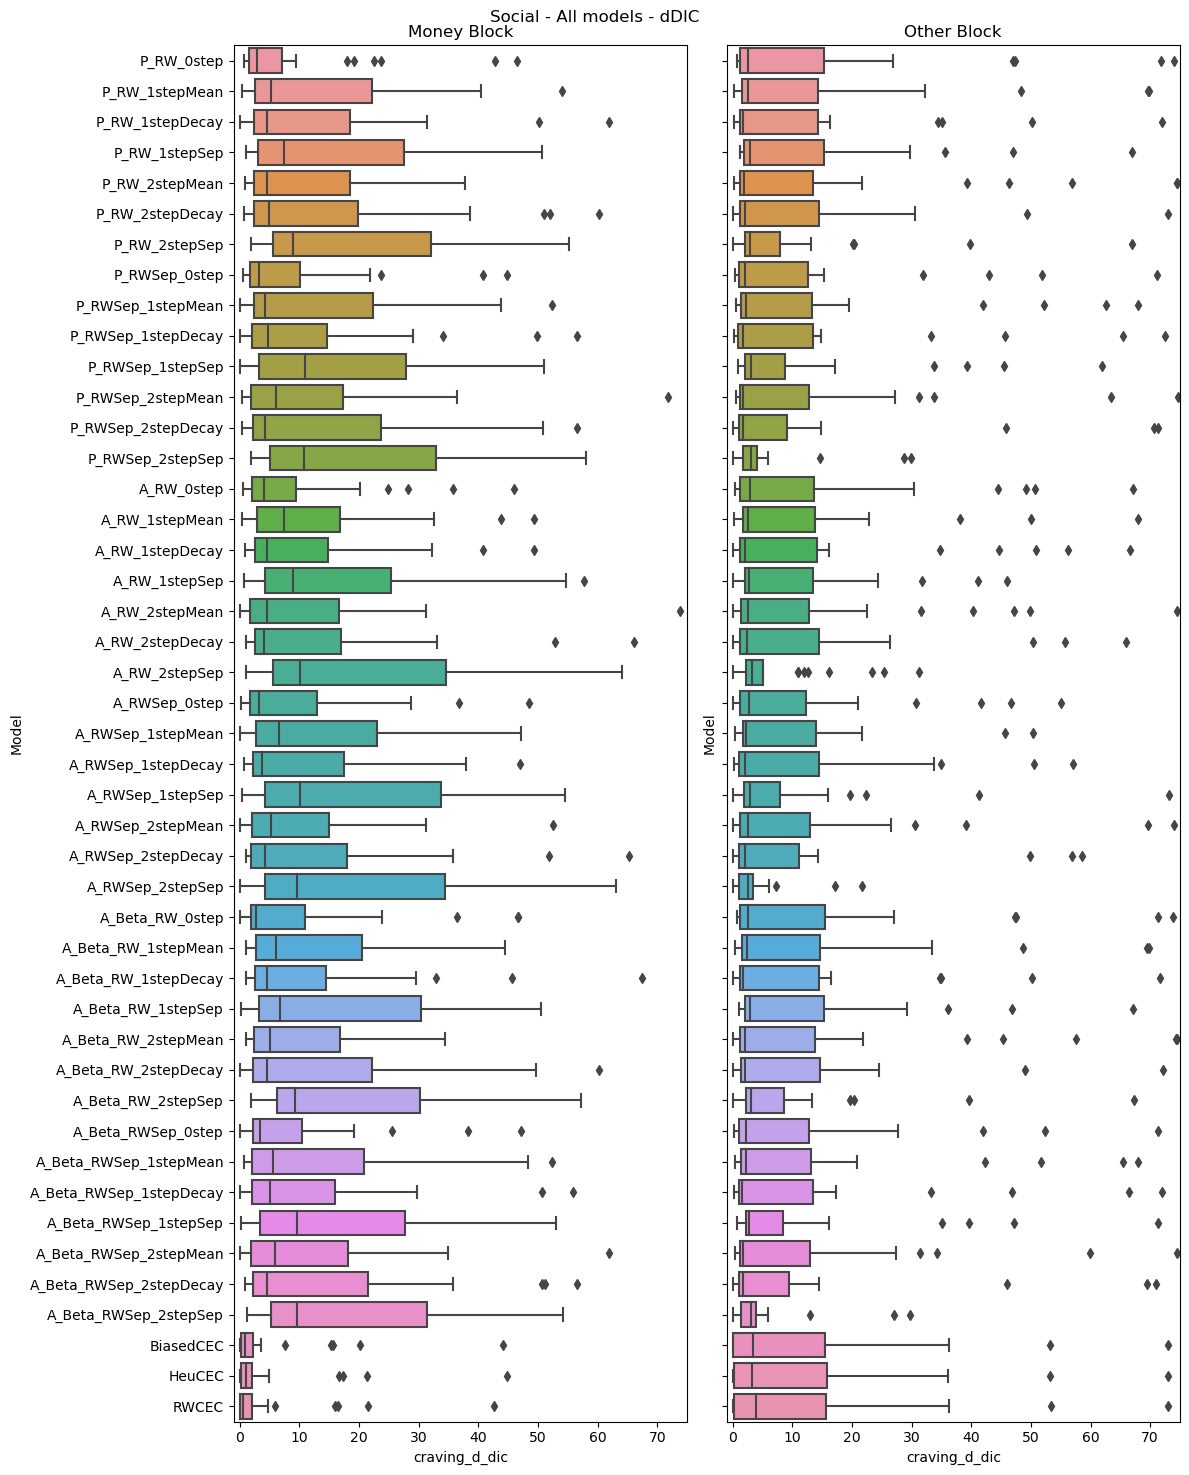

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 15), sharey=True, facecolor='w')
sns.boxplot(data=model_comp_df[model_comp_df['Block']=='money'], y='Model', x='craving_d_dic', ax=ax[0])
ax[0].set_xlim(-1, 75)
ax[0].set_title('Money Block')
sns.boxplot(data=model_comp_df[model_comp_df['Block']=='other'], y='Model', x='craving_d_dic', ax=ax[1])
ax[1].set_xlim(-1, 75)
ax[1].set_title('Other Block')
fig.suptitle(f'{group_name} - All models - dDIC')
plt.tight_layout()
plt.savefig(os.path.join(figure_save_path, 'all_model_comp_craving_d_dic.png'))

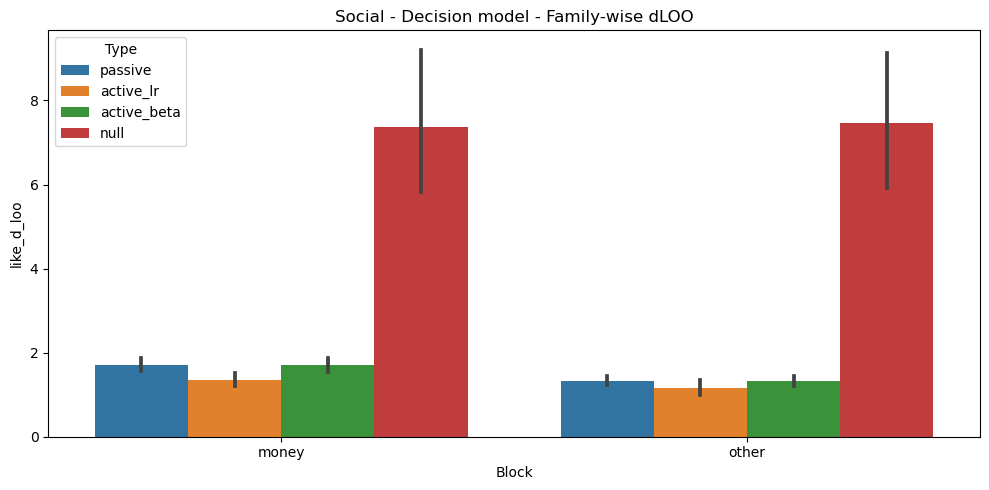

In [32]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='w')
sns.barplot(
    # data=d_waic_df.groupby(['Type', 'Block']).mean().sort_values('d_waic_like', ascending=True).reset_index(),
    data=model_comp_df,
    x='Block',
    y='like_d_loo',
    hue='Type',
)
ax.set_title(f'{group_name} - Decision model - Family-wise dLOO')
# plt.ylim(100, 210)
plt.tight_layout()
plt.savefig(os.path.join(figure_save_path, 'model_comp_like_d_loo_by_type.png'))

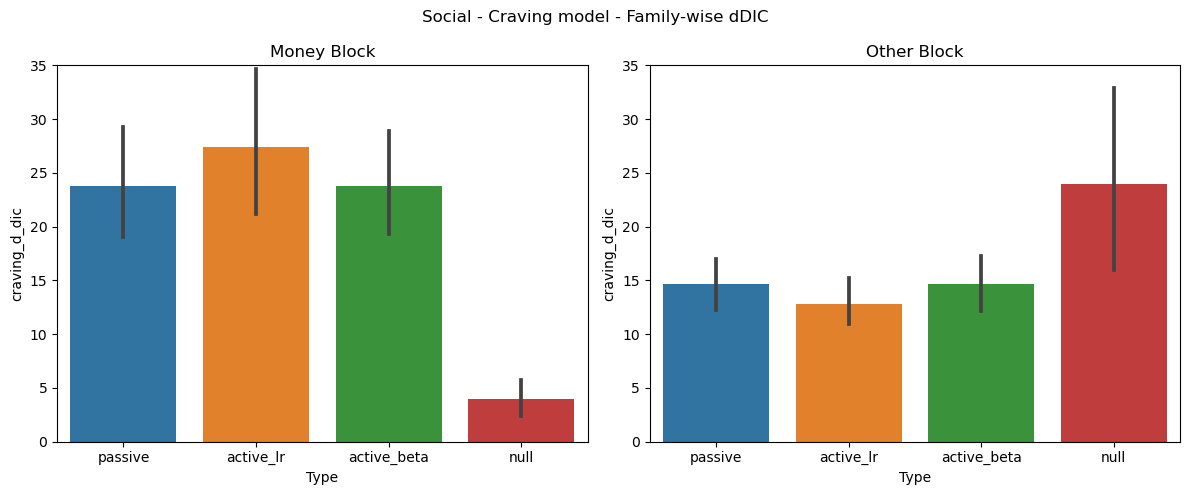

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=False, facecolor='w')
sns.barplot(
    data=model_comp_df[model_comp_df['Block']=='money'],
    x='Type',
    y='craving_d_dic',
    ax=ax[0]
)
sns.barplot(
    data=model_comp_df[model_comp_df['Block']=='other'],
    x='Type',
    y='craving_d_dic',
    ax=ax[1],
)
ax[0].set_title('Money Block')
ax[0].set_ylim(0, 35)
ax[1].set_title('Other Block')
ax[1].set_ylim(0, 35)
fig.suptitle(f'{group_name} - Craving model - Family-wise dDIC')
plt.tight_layout()
plt.savefig(os.path.join(figure_save_path, 'model_comp_craving_d_dic_by_type.png'))


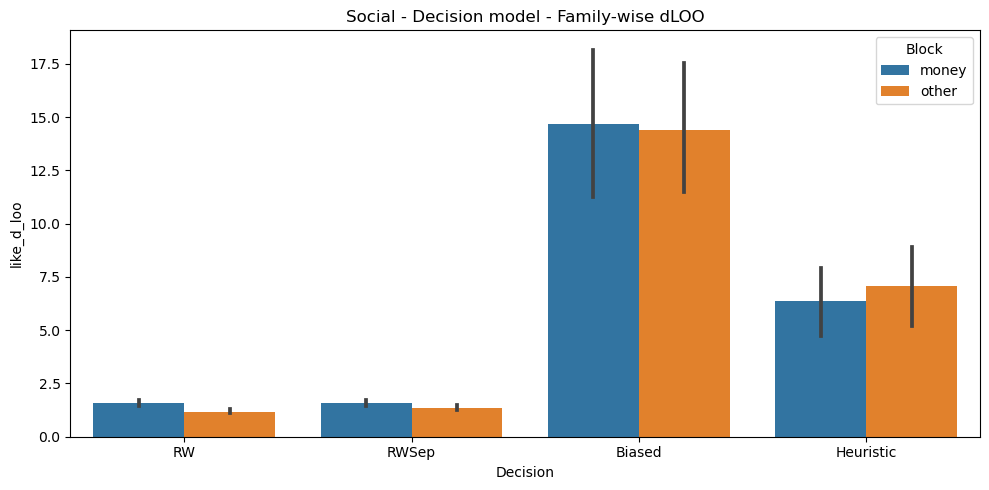

In [34]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='w')
sns.barplot(
    data=model_comp_df,
    x='Decision',
    y='like_d_loo',
    hue='Block',
)
ax.set_title(f'{group_name} - Decision model - Family-wise dLOO')
# plt.ylim(100, 210)
plt.tight_layout()
plt.savefig(os.path.join(figure_save_path, 'model_comp_like_d_loo_by_decision.png'))

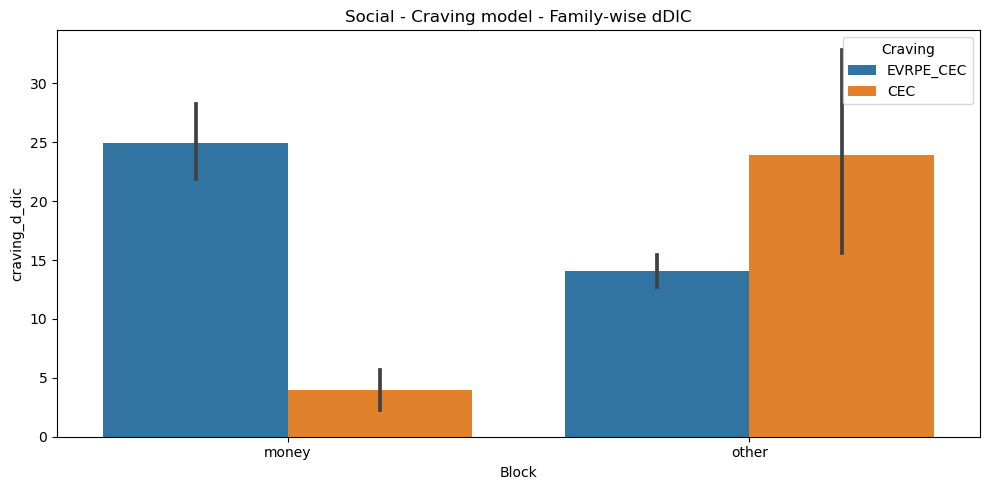

In [35]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='w')
sns.barplot(
    data=model_comp_df,
    x='Block',
    y='craving_d_dic',
    hue='Craving',
)
# ax.set_ylim(100, 125)
ax.set_title(f'{group_name} - Craving model - Family-wise dDIC')
plt.tight_layout()
plt.savefig(os.path.join(figure_save_path, 'model_comp_craving_d_dic_by_craving.png'))

In [38]:
stats.mannwhitneyu(
    model_comp_df[
        (model_comp_df['Block']=='other') & (model_comp_df['Craving']=='EVRPE_CEC')
    ]['craving_d_dic'].values,
    model_comp_df[
        (model_comp_df['Block']=='other') & (model_comp_df['Craving']=='CEC')
    ]['craving_d_dic'].values
)

MannwhitneyuResult(statistic=71425.0, pvalue=0.49428121501304445)